# MMSegmentation Tutorial
Welcome to MMSegmentation!

In this tutorial, we demo
* How to do inference with MMSeg trained weight
* How to train on your own dataset and visualize the results.

before start, revise line 11 in mmsegmentation/mmseg/__init__.py <br>
make it  <br>
MMCV_MAX = '2.2.1'

In [1]:
cd mmsegmentation

/home/test/MMdet/mmsegmentation


/home/test/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

2.8.0.dev20250422+cu128 True
1.2.2


## Finetune a semantic segmentation model on a new dataset

To finetune on a customized dataset, the following steps are necessary.
1. Add a new dataset class.
2. Create a config file accordingly.
3. Perform training and evaluation.

### Add a new dataset

Datasets in MMSegmentation require image and semantic segmentation maps to be placed in folders with the same prefix. To support a new dataset, we may need to modify the original file structure.

In this tutorial, we give an example of converting the dataset. You may refer to [docs](https://github.com/open-mmlab/mmsegmentation/blob/master/docs/en/tutorials/customize_datasets.md#customize-datasets-by-reorganizing-data) for details about dataset reorganization.

We use [Stanford Background Dataset](http://dags.stanford.edu/projects/scenedataset.html) as an example. The dataset contains 715 images chosen from existing public datasets [LabelMe](http://labelme.csail.mit.edu), [MSRC](http://research.microsoft.com/en-us/projects/objectclassrecognition), [PASCAL VOC](http://pascallin.ecs.soton.ac.uk/challenges/VOC) and [Geometric Context](http://www.cs.illinois.edu/homes/dhoiem/). Images from these datasets are mainly outdoor scenes, each containing approximately 320-by-240 pixels.
In this tutorial, we use the region annotations as labels. There are 8 classes in total, i.e. sky, tree, road, grass, water, building, mountain, and foreground object.

In [3]:
# download and unzip
!wget http://dags.stanford.edu/data/iccv09Data.tar.gz -O stanford_background.tar.gz
!tar xf stanford_background.tar.gz

--2025-04-10 15:00:40--  http://dags.stanford.edu/data/iccv09Data.tar.gz
Resolving dags.stanford.edu (dags.stanford.edu)... 171.64.68.10
Connecting to dags.stanford.edu (dags.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14727974 (14M) [application/x-gzip]
Saving to: ‘stanford_background.tar.gz’

stanford_background 100%[===================>]  14.04M  2.32MB/s    in 6.3s    

2025-04-10 15:00:47 (2.22 MB/s) - ‘stanford_background.tar.gz’ saved [14727974/14727974]



In [4]:
# dataset is not perfect, some pixels are unclassified and left as unknowns (class -1)
# we clean it by assigning unknowns as neighbour class, and drop sample if there are many unknowns
import os
import re
import numpy as np
from scipy import stats
from collections import Counter

def process_file(filepath):
    # Read matrix from file
    with open(filepath, 'r') as f:
        matrix = []
        for line in f:
            row = [float(x) for x in line.strip().split()]
            matrix.append(row)
    
    arr = np.array(matrix)
    total_values = arr.size
    negatives = arr[arr < 0]
    negative_count = len(negatives)
    
    # Case 1: More than 1% negatives - delete file
    if negative_count > 0.01 * total_values:
        os.remove(filepath)
        print(f"Deleted {filepath} ({negative_count/total_values:.2%} negatives)")
        return
    
    # Case 2: Few negatives - replace with mode of nearby values
    if negative_count > 0:
        print(f"Processing {filepath} ({negative_count} negatives)")
        rows, cols = arr.shape
        
        # Create padded array for edge handling
        padded = np.pad(arr, 1, mode='constant', constant_values=np.nan)
        
        for i in range(rows):
            for j in range(cols):
                if arr[i,j] < 0:
                    # Get 3x3 neighborhood (excluding current cell)
                    neighborhood = padded[i:i+3, j:j+3].flatten()
                    neighborhood = neighborhood[~np.isnan(neighborhood)]
                    neighborhood = neighborhood[neighborhood >= 0]  # Exclude other negatives
                    
                    if len(neighborhood) > 0:
                        # Calculate mode of positive neighbors
                        mode = stats.mode(neighborhood, keepdims=False).mode
                        arr[i,j] = mode
                    else:
                        # If no valid neighbors, use global mode
                        global_mode = stats.mode(arr[arr >= 0].flatten()).mode
                        arr[i,j] = global_mode
        
        # Save corrected file
        np.savetxt(filepath, arr, fmt='%.6f')
        print(f"Corrected {filepath}")

# Main processing
label_dir = "iccv09Data/labels/"
for filename in os.listdir(label_dir):
    if filename.endswith(".regions.txt"):
        filepath = os.path.join(label_dir, filename)
        process_file(filepath)

Processing iccv09Data/labels/4100246.regions.txt (12 negatives)
Corrected iccv09Data/labels/4100246.regions.txt
Deleted iccv09Data/labels/5000123.regions.txt (1.24% negatives)
Processing iccv09Data/labels/6000192.regions.txt (3 negatives)
Corrected iccv09Data/labels/6000192.regions.txt
Processing iccv09Data/labels/6000205.regions.txt (55 negatives)
Corrected iccv09Data/labels/6000205.regions.txt
Processing iccv09Data/labels/0101801.regions.txt (4 negatives)
Corrected iccv09Data/labels/0101801.regions.txt
Processing iccv09Data/labels/6000296.regions.txt (19 negatives)
Corrected iccv09Data/labels/6000296.regions.txt
Processing iccv09Data/labels/9001619.regions.txt (75 negatives)
Corrected iccv09Data/labels/9001619.regions.txt
Processing iccv09Data/labels/0101060.regions.txt (3 negatives)
Corrected iccv09Data/labels/0101060.regions.txt
Processing iccv09Data/labels/1000351.regions.txt (19 negatives)
Corrected iccv09Data/labels/1000351.regions.txt
Processing iccv09Data/labels/6000083.region

In [5]:
# ensure no more unknown
import os
import re

# Directory containing the label files
label_dir = "iccv09Data/labels/"
negative_files = []

# Regex pattern to match various negative number formats
negative_pattern = re.compile(r'-\d*\.?\d+')  # Matches: -1, -123, -1.23, -.5

for filename in os.listdir(label_dir):
    if filename.endswith(".regions.txt"):
        filepath = os.path.join(label_dir, filename)
        with open(filepath, 'r') as f:
            content = f.read()
            
            # Find all negative numbers in file
            negatives = negative_pattern.findall(content)
            
            if negatives:
                print(f"\nFound {len(negatives)} negative value(s) in {filename}:")
                print("Negative values:", ", ".join(negatives))
                negative_files.append(filename)

print("\n=== Summary ===")
print(f"Total files with negative values: {len(negative_files)}")
if negative_files:
    print("Affected files:")
    for f in negative_files:
        print(f" - {f}")
else:
    print("No files contain negative values.")


=== Summary ===
Total files with negative values: 0
No files contain negative values.


In [6]:
# drop the samples of unknown
import os

label_dir = "iccv09Data/labels/"

# Get all PNG files
png_files = [f for f in os.listdir(label_dir) if f.endswith('.png')]

for png in png_files:
    base_name = os.path.splitext(png)[0]  # Get filename without extension
    required_files = [
        f"{base_name}.layers.txt",
        f"{base_name}.regions.txt",
        f"{base_name}.surfaces.txt"
    ]
    
    # Check if all required files exist
    missing_files = [f for f in required_files if not os.path.exists(os.path.join(label_dir, f))]
    
    if missing_files:
        print(f"Deleting incomplete bundle for {base_name}:")
        print(f"  Missing files: {', '.join(missing_files)}")
        
        # Delete PNG
        png_path = os.path.join(label_dir, png)
        os.remove(png_path)
        print(f"  Deleted: {png}")
        
        # Delete any existing TXTs
        for txt in required_files:
            txt_path = os.path.join(label_dir, txt)
            if os.path.exists(txt_path):
                os.remove(txt_path)
                print(f"  Deleted: {txt}")
        
        print("  Bundle removed\n")

print("Cleanup complete")

Cleanup complete


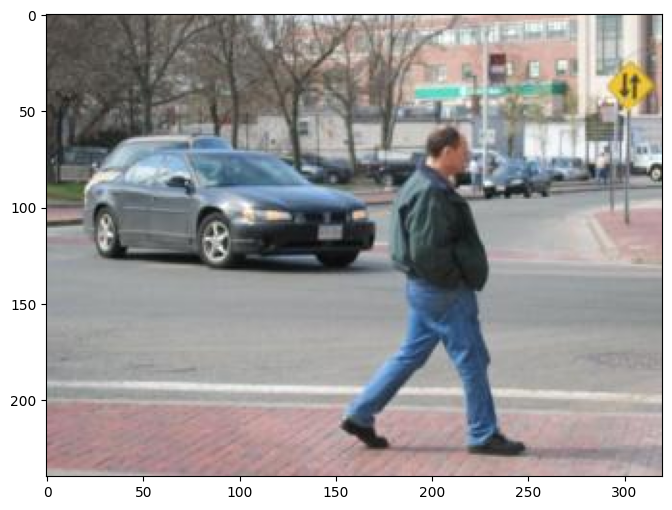

In [3]:
# Let's take a look at the dataset
import mmcv
import mmengine
import matplotlib.pyplot as plt

img = mmcv.imread('iccv09Data/images/6000124.jpg')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

We need to convert the annotation into semantic map format as an image.

In [4]:
# define dataset root and directory for images and annotations
data_root = 'iccv09Data'
img_dir = 'images'
ann_dir = 'labels'
# define class and palette for better visualization
classes = ('sky', 'tree', 'road', 'grass', 'water', 'bldg', 'mntn', 'fg obj')
palette = [[128, 128, 128], [129, 127, 38], [120, 69, 125], [53, 125, 34],
           [0, 11, 123], [118, 20, 12], [122, 81, 25], [241, 134, 51]]

In [5]:
import os.path as osp
import numpy as np
from PIL import Image

# convert dataset annotation to semantic segmentation map
for file in mmengine.scandir(osp.join(data_root, ann_dir), suffix='.regions.txt'):
  seg_map = np.loadtxt(osp.join(data_root, ann_dir, file)).astype(np.uint8)
  seg_img = Image.fromarray(seg_map).convert('P')
  seg_img.putpalette(np.array(palette, dtype=np.uint8))
  seg_img.save(osp.join(data_root, ann_dir, file.replace('.regions.txt',
                                                         '.png')))

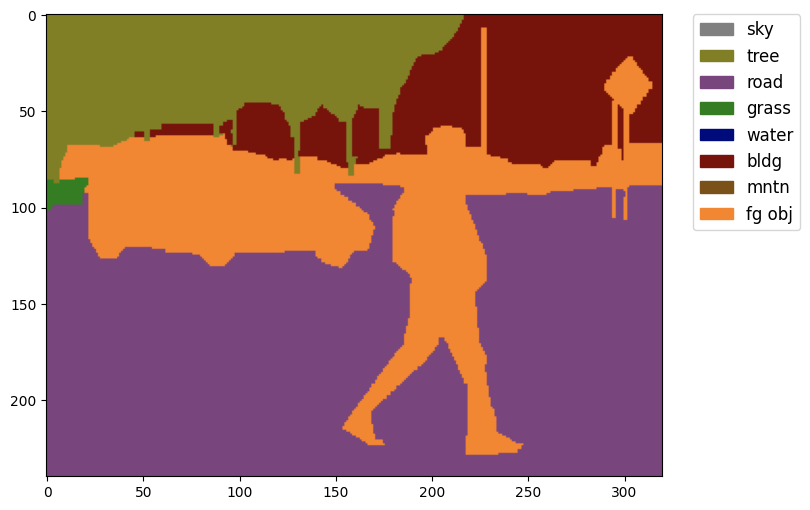

In [6]:
# Let's take a look at the segmentation map we got
import matplotlib.patches as mpatches
img = Image.open('iccv09Data/labels/6000124.png')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

# create a patch (proxy artist) for every color
patches = [mpatches.Patch(color=np.array(palette[i])/255.,
                          label=classes[i]) for i in range(8)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,
           fontsize='large')

plt.show()

# Prepare train/val split

In [7]:
# split train/val set randomly
split_dir = 'splits'
mmengine.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmengine.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  # select first 4/5 as train set
  train_length = int(len(filename_list)*4/5)
  f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  # select last 1/5 as train set
  f.writelines(line + '\n' for line in filename_list[train_length:])

After downloading the data, we need to implement `load_annotations` function in the new dataset class `StanfordBackgroundDataset`.

In [8]:
from mmseg.registry import DATASETS
from mmseg.datasets import BaseSegDataset


@DATASETS.register_module()
class StanfordBackgroundDataset(BaseSegDataset):
  METAINFO = dict(classes = classes, palette = palette)
  def __init__(self, **kwargs):
    super().__init__(img_suffix='.jpg', seg_map_suffix='.png', **kwargs)


### Create a config file
In the next step, we need to modify the config for the training. To accelerate the process, we finetune the model from trained weights.

In [9]:
# there are plenty of models
# you may check what models are available on
# https://mmsegmentation.readthedocs.io/en/latest/modelzoo_statistics.html

In [9]:
from mmengine import Config
cfg = Config.fromfile('configs/pspnet/pspnet_r50-d8_4xb2-40k_cityscapes-512x1024.py')
print(f'Config:\n{cfg.pretty_text}')

Config:
crop_size = (
    512,
    1024,
)
data_preprocessor = dict(
    bgr_to_rgb=True,
    mean=[
        123.675,
        116.28,
        103.53,
    ],
    pad_val=0,
    seg_pad_val=255,
    size=(
        512,
        1024,
    ),
    std=[
        58.395,
        57.12,
        57.375,
    ],
    type='SegDataPreProcessor')
data_root = 'data/cityscapes/'
dataset_type = 'CityscapesDataset'
default_hooks = dict(
    checkpoint=dict(by_epoch=False, interval=4000, type='CheckpointHook'),
    logger=dict(interval=50, log_metric_by_epoch=False, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
    visualization=dict(type='SegVisualizationHook'))
default_scope = 'mmseg'
env_cfg = dict(
    cudnn_benchmark=True,
    dist_cfg=dict(backend='nccl'),
    mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0))
img_ratios = [
    0.5,
    0.75,
    1.0,
    1.25,
    1.5,
    1.

Since the given config is used to train PSPNet on the cityscapes dataset, we need to modify it accordingly for our new dataset.  

In [10]:
# if we use only one GPU, BN is used instead of SyncBN
#cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.crop_size = (256, 256)
cfg.model.data_preprocessor.size = cfg.crop_size
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 8
cfg.model.auxiliary_head.num_classes = 8

# Modify dataset type and path
cfg.dataset_type = 'StanfordBackgroundDataset'
cfg.data_root = data_root

cfg.train_dataloader.batch_size = 8

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='RandomResize', scale=(320, 240), ratio_range=(0.5, 2.0), keep_ratio=True),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PackSegInputs')
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='Resize', scale=(320, 240), keep_ratio=True),
    # add loading annotation after ``Resize`` because ground truth
    # does not need to do resize data transform
    dict(type='LoadAnnotations'),
    dict(type='PackSegInputs')
]


cfg.train_dataloader.dataset.type = cfg.dataset_type
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline
cfg.train_dataloader.dataset.ann_file = 'splits/train.txt'

cfg.val_dataloader.dataset.type = cfg.dataset_type
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.val_dataloader.dataset.ann_file = 'splits/val.txt'

cfg.test_dataloader = cfg.val_dataloader


# Load the pretrained weights
cfg.load_from = 'pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/tutorial'

cfg.train_cfg.max_iters = 200
cfg.train_cfg.val_interval = 200
cfg.default_hooks.logger.interval = 10
cfg.default_hooks.checkpoint.interval = 200

# Set seed to facilitate reproducing the result
cfg['randomness'] = dict(seed=0)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
crop_size = (
    256,
    256,
)
data_preprocessor = dict(
    bgr_to_rgb=True,
    mean=[
        123.675,
        116.28,
        103.53,
    ],
    pad_val=0,
    seg_pad_val=255,
    size=(
        512,
        1024,
    ),
    std=[
        58.395,
        57.12,
        57.375,
    ],
    type='SegDataPreProcessor')
data_root = 'iccv09Data'
dataset_type = 'StanfordBackgroundDataset'
default_hooks = dict(
    checkpoint=dict(by_epoch=False, interval=200, type='CheckpointHook'),
    logger=dict(interval=10, log_metric_by_epoch=False, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
    visualization=dict(type='SegVisualizationHook'))
default_scope = 'mmseg'
env_cfg = dict(
    cudnn_benchmark=True,
    dist_cfg=dict(backend='nccl'),
    mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0))
img_ratios = [
    0.5,
    0.75,
    1.0,
    1.25,
    1.5,
    1.

### Train and Evaluation

In [11]:
from mmengine.runner import Runner

runner = Runner.from_cfg(cfg)

04/25 14:54:39 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.16 (main, Dec 11 2024, 16:24:50) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 0
    GPU 0,1: NVIDIA GeForce RTX 5090
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.8, V12.8.93
    GCC: gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.8.0.dev20250422+cu128
    PyTorch compiling details: PyTorch built with:
  - GCC 11.2
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2024.2-Product Build 20240605 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.7.1 (Git Hash 8d263e693366ef8db40acc569cc7d8edf644556d)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - CUDA Runtime 12.8
  - NVCC architecture flags: -gencode;arch=compute_75,co

/home/test/MMdet/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/home/test/MMdet/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:250: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


04/25 14:54:41 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
04/25 14:54:41 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

/home/test/MMdet/mmsegmentation/mmseg/engine/hooks/visualization_hook.py:60: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


In [12]:
# start training
runner.train()

04/25 14:54:41 - mmengine - WARNING - The prefix is not set in metric class IoUMetric.
04/25 14:54:41 - mmengine - INFO - load model from: open-mmlab://resnet50_v1c
04/25 14:54:41 - mmengine - INFO - Loads checkpoint by openmmlab backend from path: open-mmlab://resnet50_v1c
04/25 14:54:41 - mmengine - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

Loads checkpoint by local backend from path: pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([8, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([8]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape tor

/home/test/MMdet/mmengine/mmengine/logging/message_hub.py:346: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/aten/src/ATen/native/Scalar.cpp:22.)
  value = value.item()


04/25 14:54:44 - mmengine - INFO - Iter(train) [ 10/200]  lr: 9.9980e-03  eta: 0:00:41  time: 0.2164  data_time: 0.0052  memory: 19444  loss: 2.2703  decode.loss_ce: 1.5708  decode.acc_seg: 71.6417  aux.loss_ce: 0.6995  aux.acc_seg: 66.5984
04/25 14:54:44 - mmengine - INFO - Iter(train) [ 20/200]  lr: 9.9958e-03  eta: 0:00:23  time: 0.0496  data_time: 0.0036  memory: 3345  loss: 1.3882  decode.loss_ce: 0.8640  decode.acc_seg: 79.3300  aux.loss_ce: 0.5242  aux.acc_seg: 71.8145
04/25 14:54:45 - mmengine - INFO - Iter(train) [ 30/200]  lr: 9.9935e-03  eta: 0:00:17  time: 0.0495  data_time: 0.0037  memory: 3345  loss: 1.0905  decode.loss_ce: 0.6967  decode.acc_seg: 81.4362  aux.loss_ce: 0.3938  aux.acc_seg: 77.7255
04/25 14:54:45 - mmengine - INFO - Iter(train) [ 40/200]  lr: 9.9913e-03  eta: 0:00:14  time: 0.0496  data_time: 0.0037  memory: 3345  loss: 1.0067  decode.loss_ce: 0.6615  decode.acc_seg: 80.9734  aux.loss_ce: 0.3452  aux.acc_seg: 84.4412
04/25 14:54:46 - mmengine - INFO - Iter

EncoderDecoder(
  (data_preprocessor): SegDataPreProcessor()
  (backbone): ResNetV1c(
    (stem): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): _BatchNormXd(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): _BatchNormXd(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (7): _BatchNormXd(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): _BatchNormXd(64, eps=

In [16]:
import torch
#after training, clear cache
torch.cuda.empty_cache()
torch.cuda.synchronize()

Inference with trained model

/home/test/MMdet/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:250: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: ./work_dirs/tutorial/iter_200.pth


/home/test/MMdet/mmengine/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


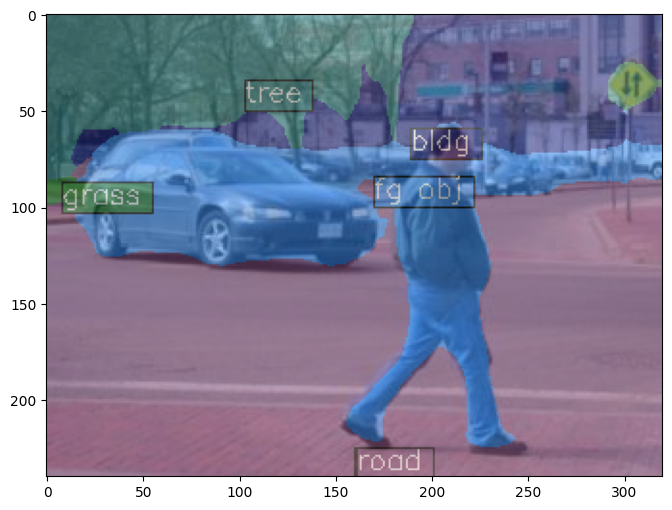

In [15]:
from mmseg.apis import init_model, inference_model, show_result_pyplot

# Init the model from the config and the checkpoint
checkpoint_path = './work_dirs/tutorial/iter_200.pth'
model = init_model(cfg, checkpoint_path, 'cuda:0')

img = mmcv.imread('iccv09Data/images/6000124.jpg')
result = inference_model(model, img)
plt.figure(figsize=(8, 6))
vis_result = show_result_pyplot(model, img, result)
plt.imshow(mmcv.bgr2rgb(vis_result))
